
# R : SDM : Montane woodcreper
-----------------------

BIO401-01/598-02 
 
Apr. 7 2021


## Preparation
 
    > install.packages("rworldmap")
    > install.packages("maptools")
    > install.packages("rgeos")
    > install.packages("reshape")

In [121]:
library(ggplot2)
library(rworldmap)
library(rgdal)
library(raster)
library(maptools)
library(rgeos)
library(reshape)
library(rasterVis)
library(dismo)
library(caret)
library(InformationValue)

In [3]:
set.seed(30)

## Data Exploration

We will use Montane woodcreper (Lepidocolaptes lacrymiger) as example species. 

This species has a large range, occurring from the coastal cordillera of Venezuela along the Andes south to south-east Peru and central Bolivia.

<img src='./images/Montane_Woodcreeper.jpg' width="400">

### Read in points data 

In [4]:
birdrange <- readOGR("./geodata/shp", "cartodb-query")

OGR data source with driver: ESRI Shapefile 
Source: "/home/eagle/Arbeit/Venture_Creation/Spatial_Ecology/Teaching_Materials/Git/SE_data/exercise/geodata/shp", layer: "cartodb-query"
with 2 features
It has 7 fields


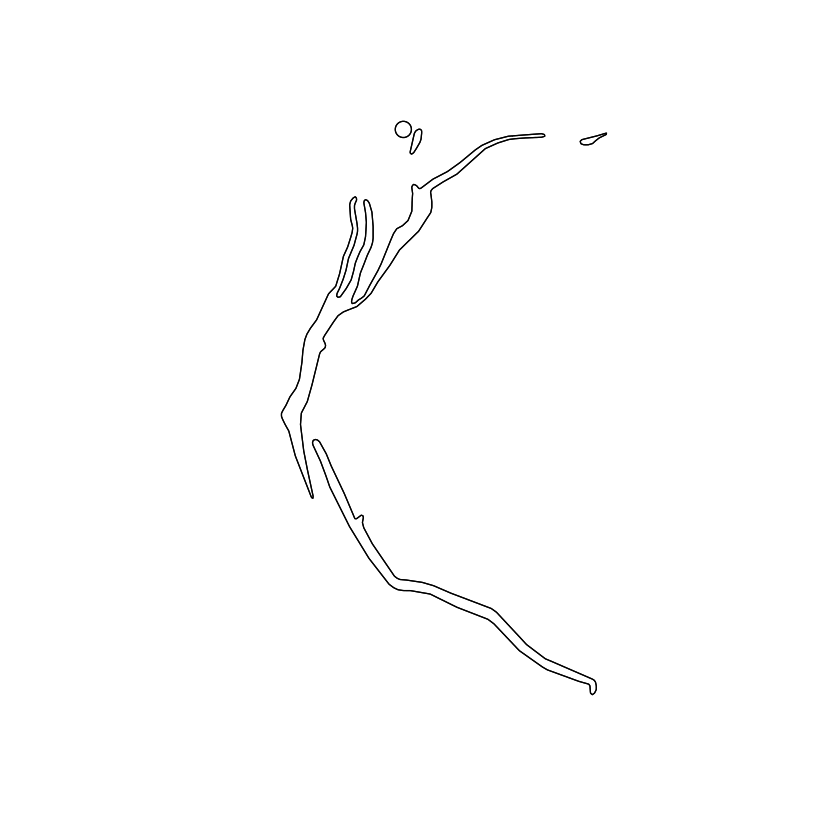

In [5]:
plot(birdrange)

In [6]:
 points <- read.csv("./geodata/shp/Lepidocolaptes_lacrymiger_allpoints.csv")
 head(points)

,lon,lat,scientific_name
,<dbl>,<dbl>,<chr>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger


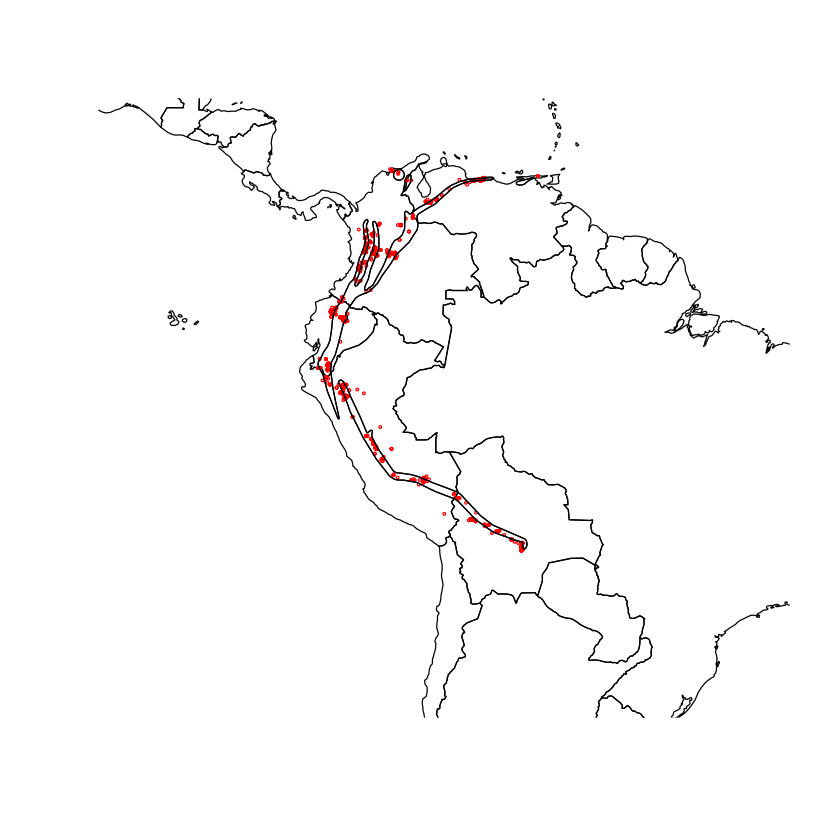

In [7]:
mapSA <- getMap(resolution = "low")
plot(mapSA, xlim = c(-80, -60), ylim = c(-30, 15), asp = 1)
points(points$lon, points$lat, col = "red", cex = .3)
plot(birdrange,add=TRUE)

In [8]:
# indicate that these data are presences
presence <- matrix(1,nrow(points),1)
points <- cbind(points,presence)

In [8]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


In [9]:
# building spatial dataframe
points <- SpatialPointsDataFrame(points[,c(1,2)], points)

In [10]:
class(points)

[1] "SpatialPointsDataFrame"
attr(,"package")
[1] "sp"

In [11]:
# assign projection
projection(points) <- "+proj=longlat +datum=WGS84" 

In [12]:
head(points)

,lon,lat,scientific_name,presence
,<dbl>,<dbl>,<chr>,<dbl>
1,-76.18925,3.98125,Lepidocolaptes_lacrymiger,1
2,-76.18406,3.93442,Lepidocolaptes_lacrymiger,1
3,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
4,-74.30256,4.60675,Lepidocolaptes_lacrymiger,1
5,-76.10394,4.74631,Lepidocolaptes_lacrymiger,1
6,-76.13861,4.74536,Lepidocolaptes_lacrymiger,1


Loading eBird sampling dataset, in order to obtain “absence” data

In [13]:
# link to global sampling raster
gsampling <- raster("./geodata/SDM/eBirdSampling_filtered.tif")

In [14]:
# crop to species range to create modelling domain
sampling <- crop(gsampling,birdrange)   

In [15]:
# assign projection
projection(sampling)="+proj=longlat +datum=WGS84"

In [16]:
# convert to points within data region
samplingp <- as(sampling,"SpatialPointsDataFrame")

In [23]:
head(samplingp)

,eBirdSampling_filtered
,<dbl>
1,0
2,0
3,0
4,0
5,0
6,0


In [17]:
samplingp <- samplingp[samplingp$eBirdSampling_filtered>0,]

In [18]:
head(samplingp@data)

,eBirdSampling_filtered
,<dbl>
687,2
783,1
785,1
786,1
1241,2
2710,4


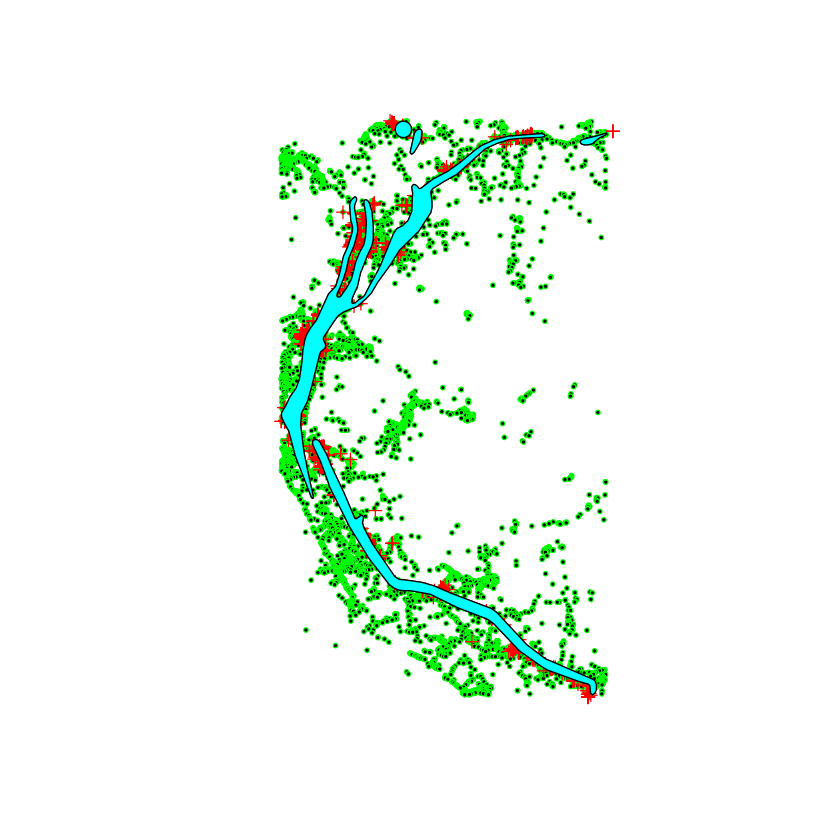

In [19]:
 # edit column names
 colnames(samplingp@data) <- c("observation")
 samplingp$presence=0
 plot(samplingp, col="green",pch=21,cex=.5)#absences
 plot(points, col="red",add=TRUE)#presences
 plot(birdrange, col="cyan",add=TRUE)#species range

In [30]:
head(samplingp)

,observation,presence
,<dbl>,<dbl>
687,2,0
783,1,0
785,1,0
786,1,0
1241,2,0
2710,4,0


combine presence and non-presence point datasets

In [20]:
pdata <- rbind(points[,"presence"],samplingp[,"presence"])
pdata@data[,c("lon","lat")] <- coordinates(pdata)
table(pdata$presence)


    0     1 
13188  3438 

### Read the environmental data layers

In [21]:
rCld <- raster("./geodata/cloud/SA_meanannual.tif")
rCldIA <-  raster("./geodata/cloud/SA_intra.tif")
rElv <- raster("./geodata/dem/SA_elevation_mn_GMTED2010_mn.tif")
rVeg <- raster("./geodata/vegetation/SA_tree_mn_percentage_GFC2013.tif")

In [22]:
rVeg[rVeg < 1e-5 ] <- NA 

In [23]:
rCld <- mask(rCld, rVeg) 
rCldIA <- mask(rCldIA, rVeg) 
rElv <- mask(rElv, rVeg)

In [24]:
env <- stack(c(rCld,rCldIA,rElv,rVeg))
env

class      : RasterStack 
dimensions : 8400, 5880, 49392000, 4  (nrow, ncol, ncell, nlayers)
resolution : 0.008333333, 0.008333333  (x, y)
extent     : -83, -34, -56, 14  (xmin, xmax, ymin, ymax)
crs        : +proj=longlat +datum=WGS84 +no_defs 
names      : SA_meanannual, SA_intra, SA_elevation_mn_GMTED2010_mn, SA_tree_mn_percentage_GFC2013 
min values :           543,        0,                         -400,                             1 
max values :         10000,     3790,                         6599,                         10000 


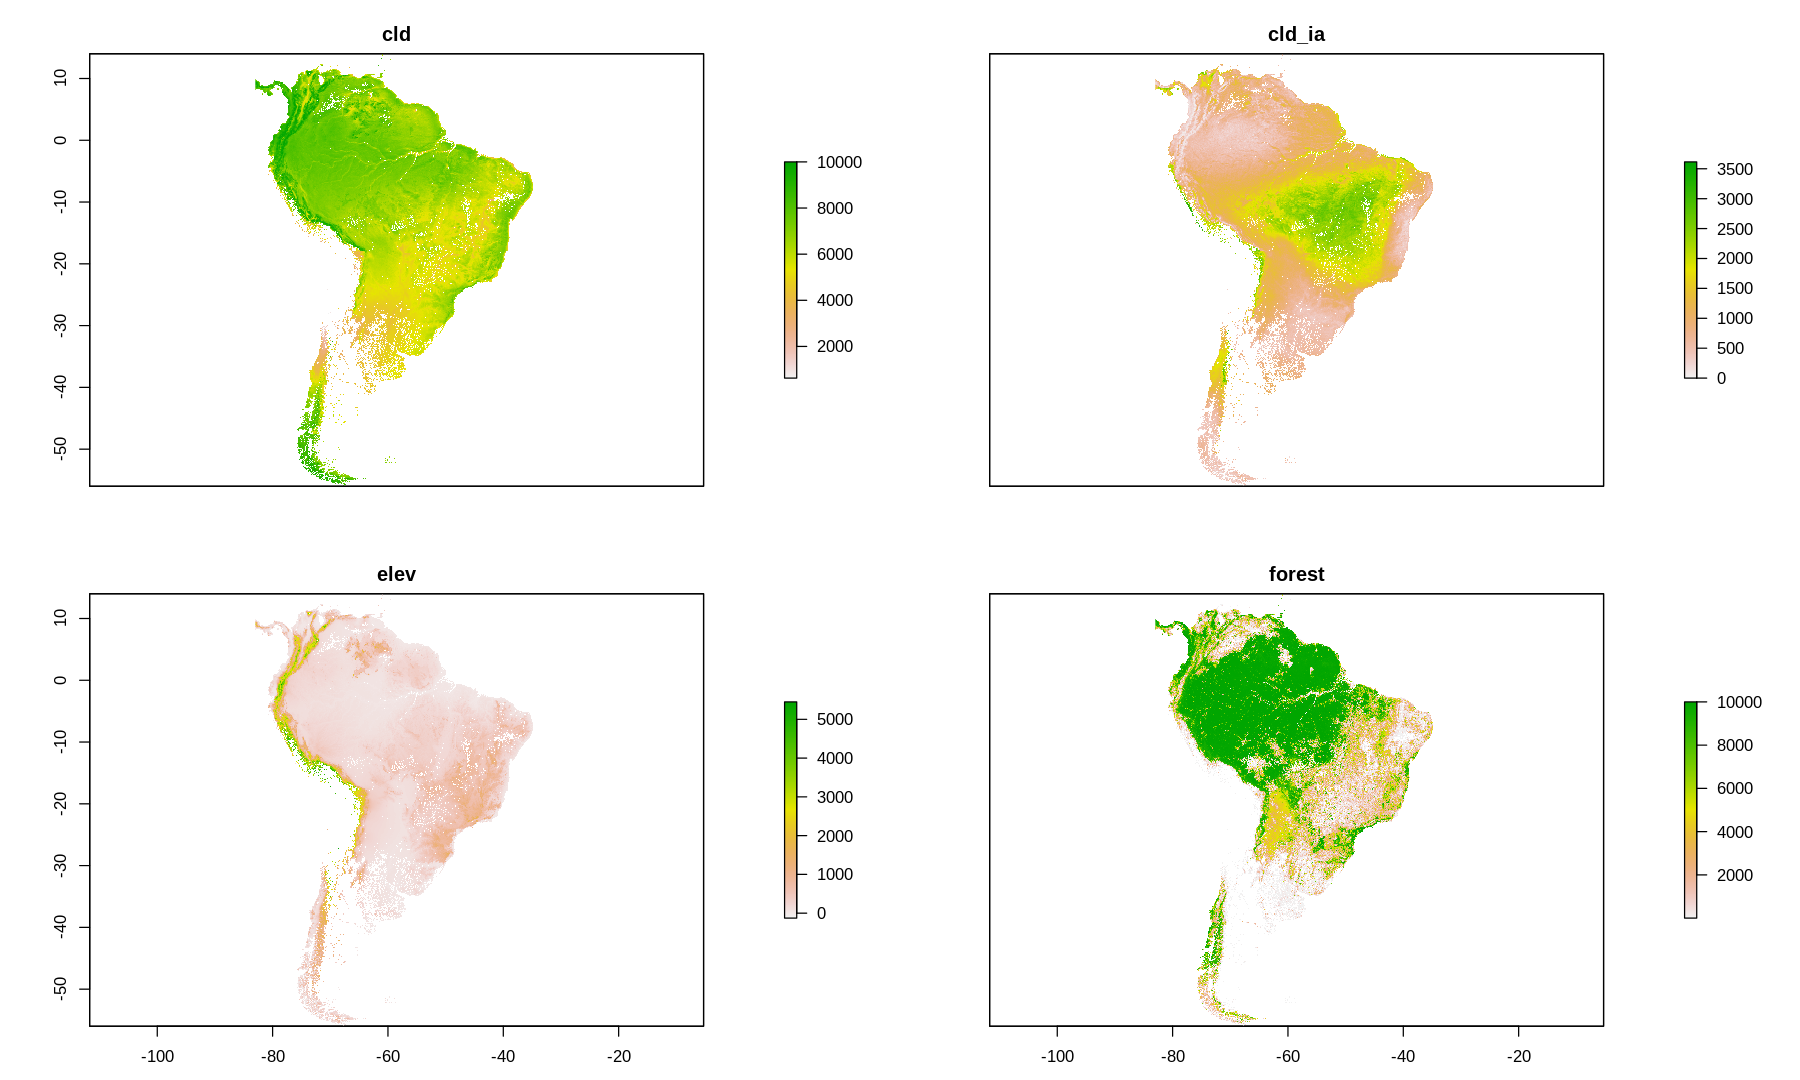

In [25]:
# rename layers for convenience
vars <- c("cld","cld_ia","elev","forest")

names(env) <- vars
 
# visual result 
options(repr.plot.width=15, repr.plot.height=9)
 # check out the plot
plot(env)

Scaling and centering the environmental variables to zero mean and variance of 1

In [42]:
senv <- scale(env[[vars]])

Annotate the point records with the scaled environmental data

In [105]:
df.xact <- raster::extract(senv,pdata,sp=T) 

In [106]:
df.xact <- (df.xact[! is.na(df.xact$forest),])

### Correlation plots

In [48]:
## convert to 'long' format for easier plotting
df.xactl <- reshape::melt(df.xact@data,id.vars=c("lat","lon","presence"),variable.name="variable")

In [49]:
head(df.xactl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
1,3.98125,-76.18925,1,cld,1.989757
2,3.93442,-76.18406,1,cld,2.368440
3,4.60675,-74.30256,1,cld,2.727681
4,4.60675,-74.30256,1,cld,2.727681
5,4.74631,-76.10394,1,cld,1.349885
6,4.74536,-76.13861,1,cld,1.720960


In [50]:
tail(df.xactl)

,lat,lon,presence,variable,value
,<dbl>,<dbl>,<dbl>,<fct>,<dbl>
58647,-18.48749,-63.83750,0,forest,-1.3229418
58648,-18.52083,-63.21250,0,forest,-1.3052032
58649,-18.53749,-63.92917,0,forest,-0.6576213
58650,-18.54583,-63.94583,0,forest,-0.3798007
58651,-18.55416,-63.98750,0,forest,-0.4837336
58652,-18.56249,-69.11250,0,forest,-1.3981432


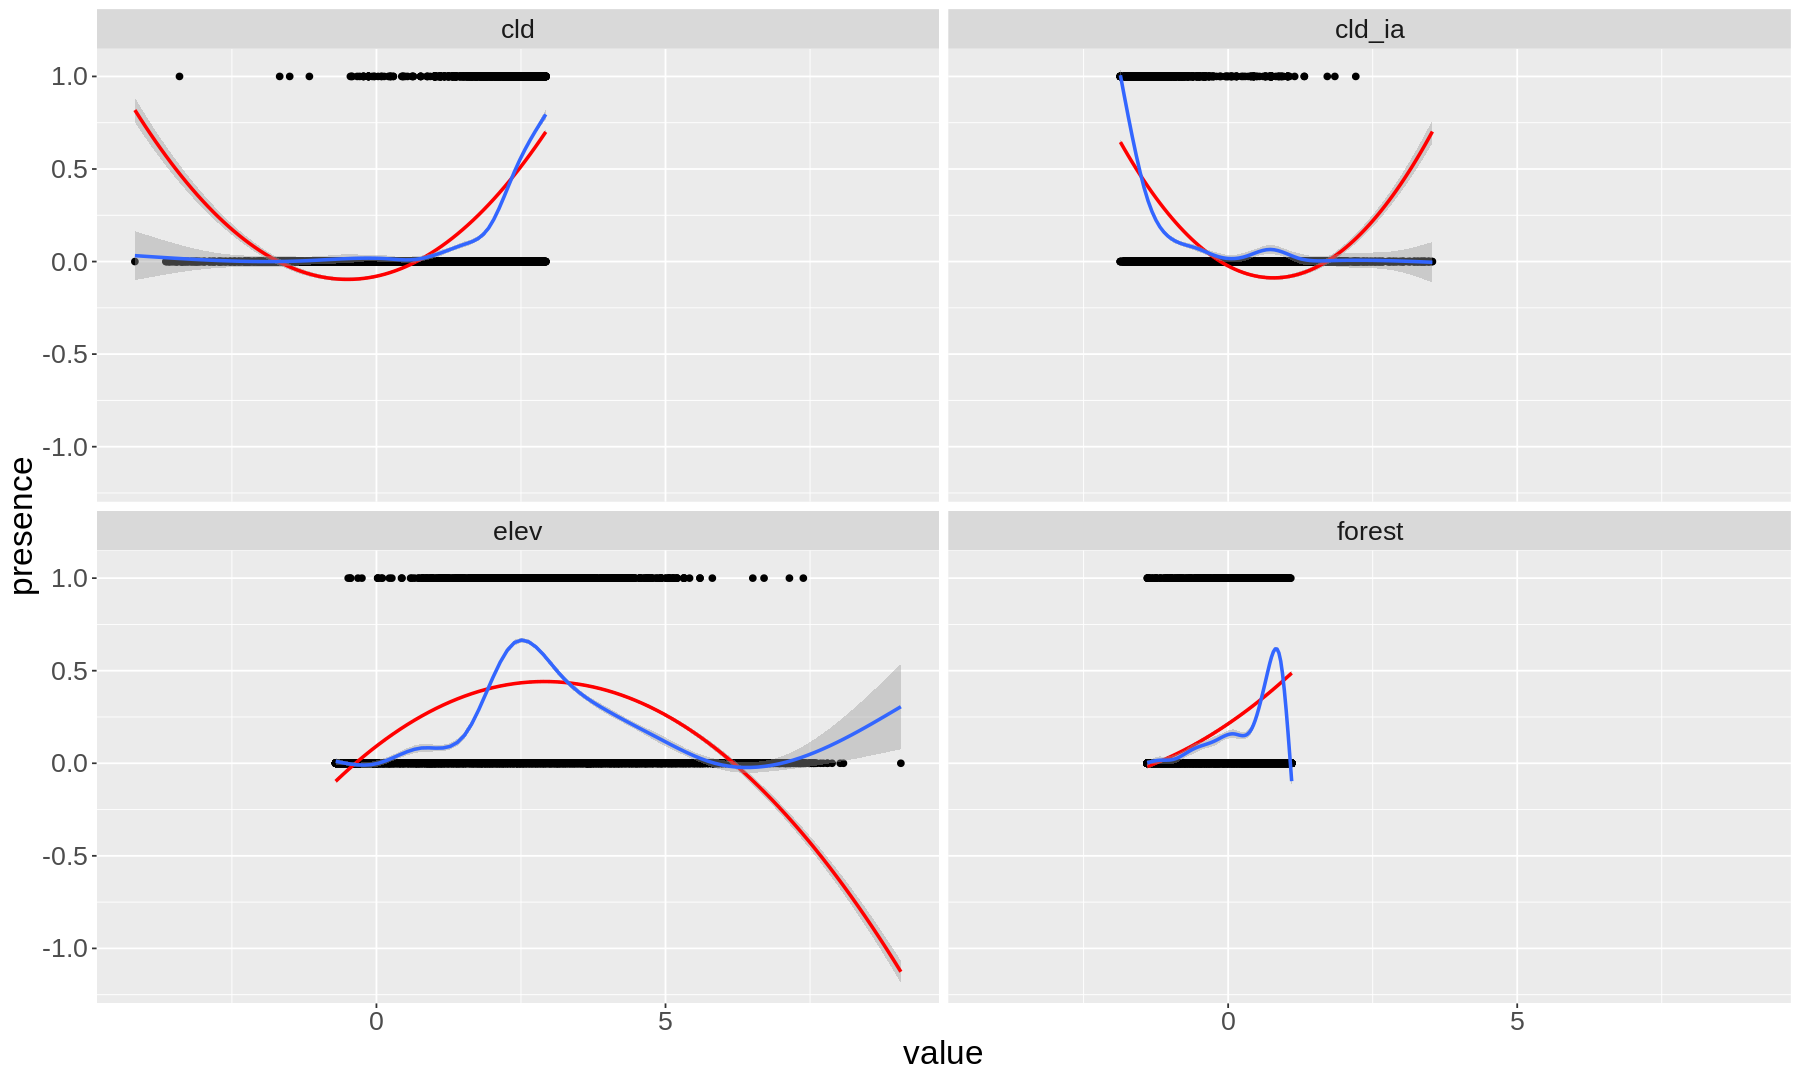

In [51]:
ggplot(df.xactl,aes(x=value,y=presence))+facet_wrap(~variable)+
  geom_point()+
  stat_smooth(method = "lm", formula = y ~ x + I(x^2), col="red")+
  geom_smooth(method="gam",formula=y ~ s(x, bs = "cs")) + 
  theme(text = element_text(size = 20))  

### Model Fitting


cross validation 


<img src='./images/cross_vld.gif' width="600">

In [107]:
ctrl <- trainControl(method = "cv", number = 5)

In [108]:
df.xact$presence <- as.factor(df.xact$presence)
df.xact <- as.data.frame(df.xact)

In [111]:
head(df.xact)

,presence,lon,lat,cld,cld_ia,elev,forest,lon.1,lat.1
,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,1,-76.18925,3.98125,1.989757,-1.521857,1.434135,0.1293705,-76.18925,3.98125
2,1,-76.18406,3.93442,2.368440,-1.531062,2.014616,0.6920072,-76.18406,3.93442
3,1,-74.30256,4.60675,2.727681,-1.733559,3.689476,0.3532259,-74.30256,4.60675
4,1,-74.30256,4.60675,2.727681,-1.733559,3.689476,0.3532259,-74.30256,4.60675
5,1,-76.10394,4.74631,1.349885,-1.262599,2.205833,0.8339156,-76.10394,4.74631
6,1,-76.13861,4.74536,1.720960,-1.396063,2.272418,0.4451666,-76.13861,4.74536


In [112]:
mdl.glm <- train(presence~cld+cld_ia+elev*I(elev^2)+forest,, data = df.xact, method = "glm", trControl = ctrl)
mdl.rf <- train(presence~cld+cld_ia+elev+forest,, data = df.xact, method = "rf", trControl = ctrl)

In [113]:
print(mdl.glm)

Generalized Linear Model 

14663 samples
    4 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11730, 11731, 11731, 11730, 11730 
Resampling results:

  Accuracy   Kappa    
  0.8772418  0.6660526



In [99]:
summary(mdl.glm)


Call:
NULL

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-1.9564  -0.2988  -0.0293  -0.0010   4.6479  

Coefficients:
                 Estimate Std. Error z value Pr(>|z|)    
(Intercept)      -8.30441    0.28170 -29.479  < 2e-16 ***
cld               1.14416    0.09303  12.299  < 2e-16 ***
cld_ia            0.18656    0.09500   1.964   0.0495 *  
elev              4.50988    0.29101  15.497  < 2e-16 ***
`I(elev^2)`      -1.07583    0.09922 -10.843  < 2e-16 ***
forest            1.44479    0.05960  24.243  < 2e-16 ***
`elev:I(elev^2)`  0.06922    0.01063   6.510 7.49e-11 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for binomial family taken to be 1)

    Null deviance: 15964.4  on 14662  degrees of freedom
Residual deviance:  7850.8  on 14656  degrees of freedom
AIC: 7864.8

Number of Fisher Scoring iterations: 9


In [100]:
print(mdl.rf)

Random Forest 

14663 samples
    4 predictor
    2 classes: '0', '1' 

No pre-processing
Resampling: Cross-Validated (5 fold) 
Summary of sample sizes: 11730, 11730, 11731, 11731, 11730 
Resampling results across tuning parameters:

  mtry  Accuracy   Kappa    
  2     0.9202075  0.7794273
  3     0.9189117  0.7764878
  4     0.9176842  0.7737408

Accuracy was used to select the optimal model using the largest value.
The final value used for the model was mtry = 2.


In [101]:
summary(mdl.rf)

                Length Class      Mode     
call                4  -none-     call     
type                1  -none-     character
predicted       14663  factor     numeric  
err.rate         1500  -none-     numeric  
confusion           6  -none-     numeric  
votes           29326  matrix     numeric  
oob.times       14663  -none-     numeric  
classes             2  -none-     character
importance          4  -none-     numeric  
importanceSD        0  -none-     NULL     
localImportance     0  -none-     NULL     
proximity           0  -none-     NULL     
ntree               1  -none-     numeric  
mtry                1  -none-     numeric  
forest             14  -none-     list     
y               14663  factor     numeric  
test                0  -none-     NULL     
inbag               0  -none-     NULL     
xNames              4  -none-     character
problemType         1  -none-     character
tuneValue           1  data.frame list     
obsLevels           2  -none-   

### Prediction

Calculate estimates of p(occurrence) for each cell.
We can use the predict function in the raster package to make the predictions across the full raster grid and save the output.

In [116]:
pred.glm <- predict(mdl.glm,df.xact[,vars],type="prob")
pred.rf <- predict(mdl.rf,df.xact[,vars],type="prob")

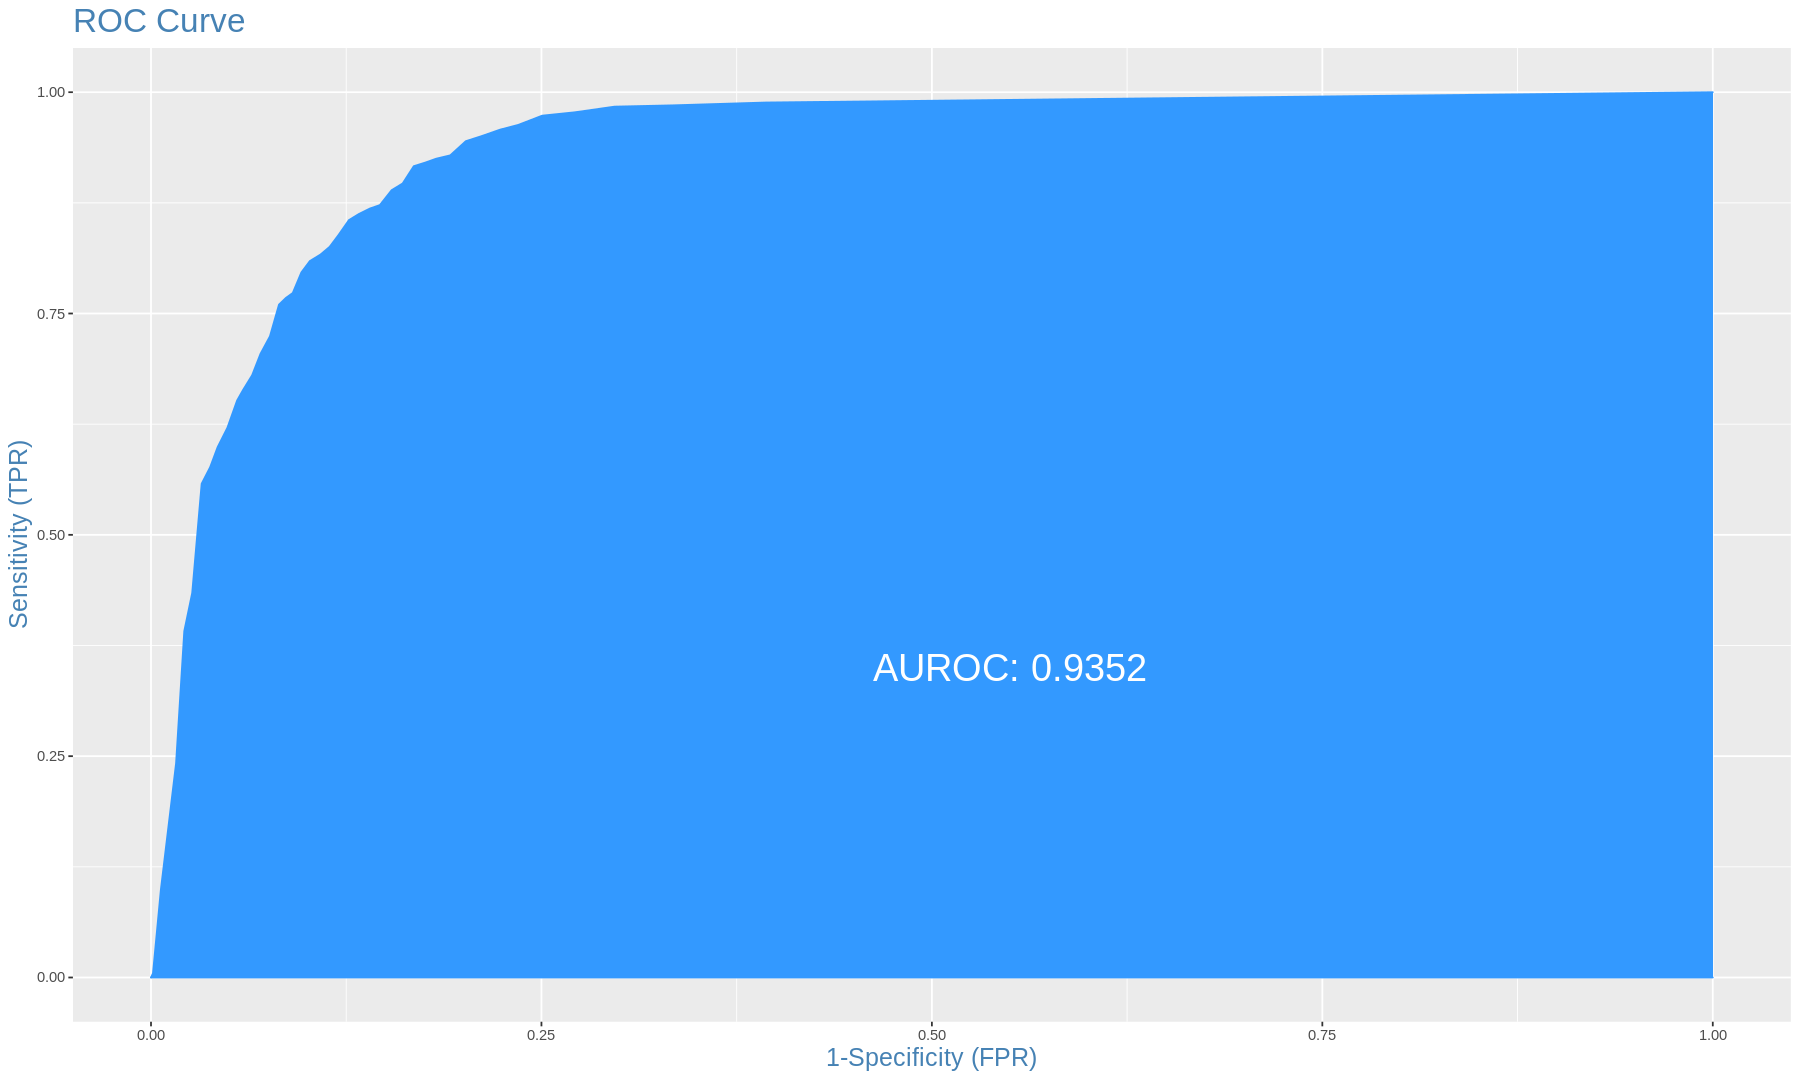

In [125]:
plotROC(df.xact$presence,pred.glm[,2])

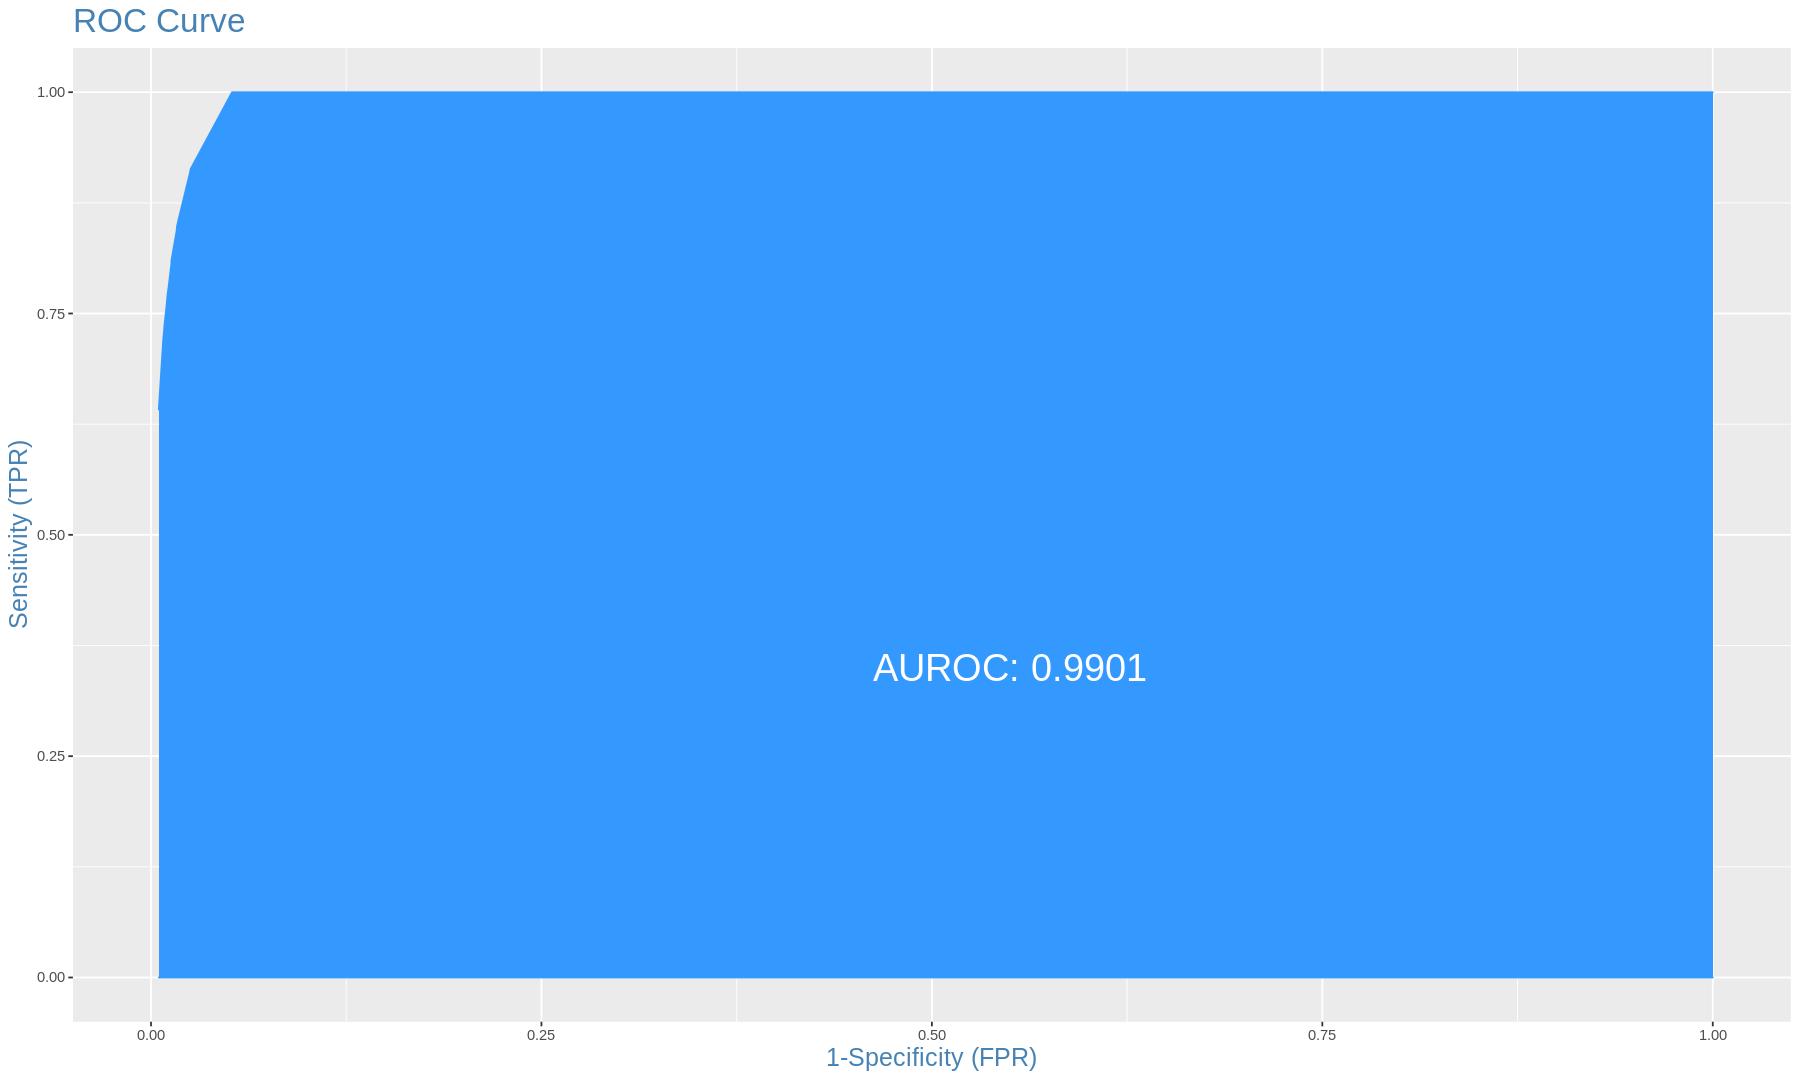

In [126]:
plotROC(df.xact$presence,pred.rf[,2])

### Out mapping

In [134]:
p1 <- raster::predict(senv,mdl.glm,type="prob")
p2 <- raster::predict(senv,mdl.rf,type="prob")
p <- stack(p1,p2); names(p)=c("Model 1","Model 2")

Warning message in if (drop) {:
“the condition has length > 1 and only the first element will be used”


ERROR: Error in if (drop) {: argument is not interpretable as logical


Plot the results as a map:

Regions defined for each Polygons



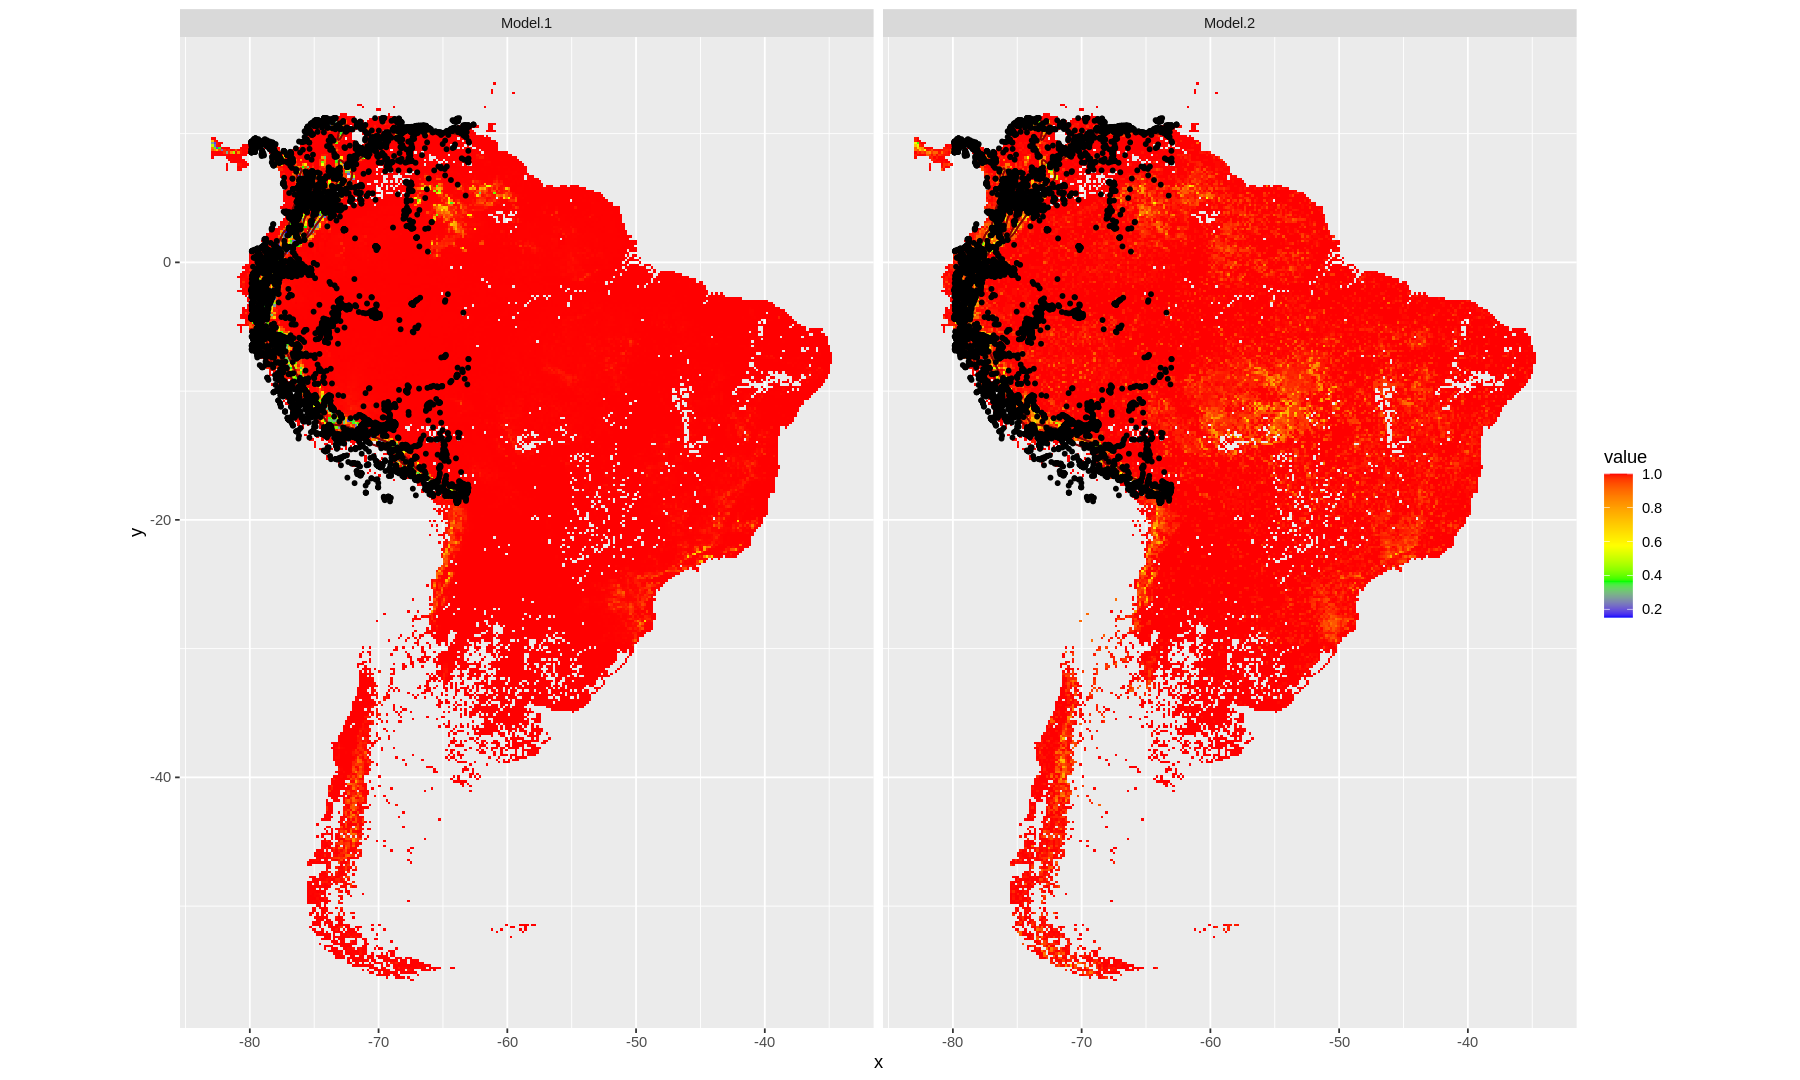

In [135]:
gplot(p,max=1e5)+geom_tile(aes(fill=value))+
  facet_wrap(~variable)+
  scale_fill_gradientn(
    colours=c("blue","green","yellow","orange","red"),
    na.value = "transparent")+
  geom_polygon(aes(x=long,y=lat,group=group),
               data=fortify(birdrange),fill="transparent",col="darkred")+
  geom_point(aes(x = lon, y = lat), data = df.xact,col="black",size=1)+
  coord_equal()

## References

- https://en.wikipedia.org/wiki/Cross-validation
- https://en.wikipedia.org/wiki/Cohen%27s_kappa
- https://en.wikipedia.org/wiki/Akaike_information_criterion
- https://en.wikipedia.org/wiki/Random_forest